In [44]:
import pandas as pd 
import pyodbc
import warnings
warnings.simplefilter('ignore')
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [45]:
DB = {
    'servername': 'tcp:dwhunitedoutdoors.database.windows.net,1433',
    'database': 'DWH_United_Outdoors',
    'username': 'onderzoeker',
    'password': 'Wachtwoord1.' 
}

conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=' + DB['servername'] + ';'
    'DATABASE=' + DB['database'] + ';'
    'UID=' + DB['username'] + ';'
    'PWD=' + DB['password'] + ';'
    'Encrypt=yes;'
    'TrustServerCertificate=no;'
    'Connection Timeout=30;'
)

dwh_conn = pyodbc.connect(conn_str)
dwh_cursor = dwh_conn.cursor()
dwh_cursor 

In [46]:
DB = {'servername':'-PC\\SQLEXPRESS', 'database':'Northwind'}

export_conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER='+ DB['servername']+ ';DATABASE='+ DB['database']+ ';Trusted_Connection=yes')
export_cursor = export_conn.cursor()
export_cursor

hier moeten de merged tables komen

In [47]:
query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"

# Voer de query uit
dwh_cursor.execute(query)

# Haal de resultaten op en print de tabelnamen
tables = dwh_cursor.fetchall()
for table in tables:
    print(table.TABLE_NAME)

Sales_SalesTerritory
Sales_SpecialOffer
Sales_SpecialOfferProduct
Sales_SalesReason
Sales_SalesTaxRate
Sales_CountryRegionCurrency
Sales_Currency
Sales_CurrencyRate
HumanResources_Shift
Person_StateProvince
Person_CountryRegion
PRODUCT
Shippers
EmployeeTerritories
Categories
PURCHASE
PRODUCTVENDOR
PRODUCTINVENTORY
PRODUCTIONLOCATION
WORKORDER
BILLOFMATERIALS
table_test
DATE
Sales_Store
Employees_Territories
OrderDetails
Region
Territories
Combined_Product
Combined_Customer
Combined_Employee
Bonus
Department
Sales_Order_Item
Sales_Order


In [48]:
def read_data_from_DWH(table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, dwh_conn)

def read_data_from_Northwind(table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, export_conn)

df_Sales_SalesTerritory = read_data_from_DWH('Sales_SalesTerritory')
df_Sales_SpecialOffer = read_data_from_DWH('Sales_SpecialOffer')
df_PRODUCTINVENTORY = read_data_from_DWH('PRODUCTINVENTORY')
df_WORKORDER = read_data_from_DWH('WORKORDER')
df_PURCHASE = read_data_from_DWH('PURCHASE')
df_product = read_data_from_DWH('PRODUCT')



In [75]:
df_product.columns

Index(['PRODUCT_id', 'PRODUCT_name', 'PRODUCT_standard_cost',
       'PRODUCT_list_price', 'PRODUCT_LINE_code', 'PRODUCT_CLASS_code',
       'PRODUCT_STYLE_code', 'Product_MODEL_name', 'Product_CULTURE_name',
       'PRODUCT_SUBCATEGORY_name', 'PRODUCT_CATEGORY_name', 'PRODUCT_color',
       'PRODUCT_modified_date'],
      dtype='object')

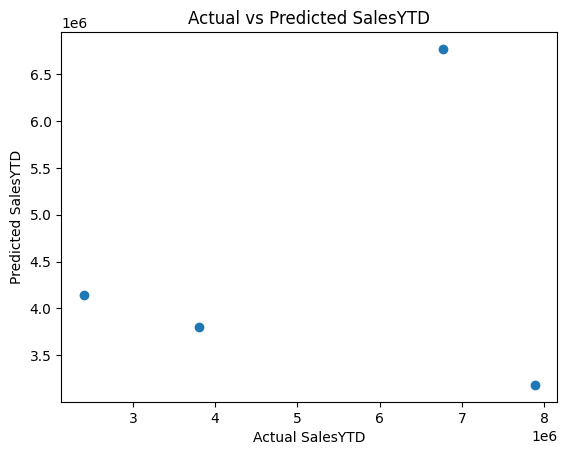

Mean Squared Error: 6287033523594.708
Mean Absolute Error: 1610204.4425286944


In [50]:
df = df_Sales_SalesTerritory  


selected_columns = ['SalesLastYear', 'Group', 'CountryRegionCode'] 


y = df['SalesYTD']


X = pd.get_dummies(df[selected_columns])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual SalesYTD')
plt.ylabel('Predicted SalesYTD')
plt.title('Actual vs Predicted SalesYTD')
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

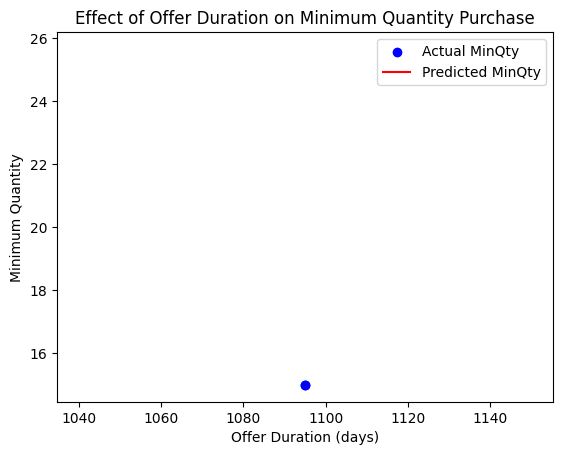

Mean Squared Error: 113.7777777777778
Mean Absolute Error: 10.666666666666668


In [67]:
df= df_Sales_SpecialOffer

df['StartDate'] = pd.to_datetime(df['StartDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])


df['OfferDuration'] = (df['EndDate'] - df['StartDate']).dt.days


X = df[['OfferDuration']]  
y = df['MinQty']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


plt.scatter(X_test, y_test, color='blue', label='Actual MinQty')
plt.plot(X_test, y_pred, color='red', label='Predicted MinQty')
plt.xlabel('Offer Duration (days)')
plt.ylabel('Minimum Quantity')
plt.title('Effect of Offer Duration on Minimum Quantity Purchase')
plt.legend()
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 2.465688619242978e-05
Mean Absolute Error: 0.003988719410001026


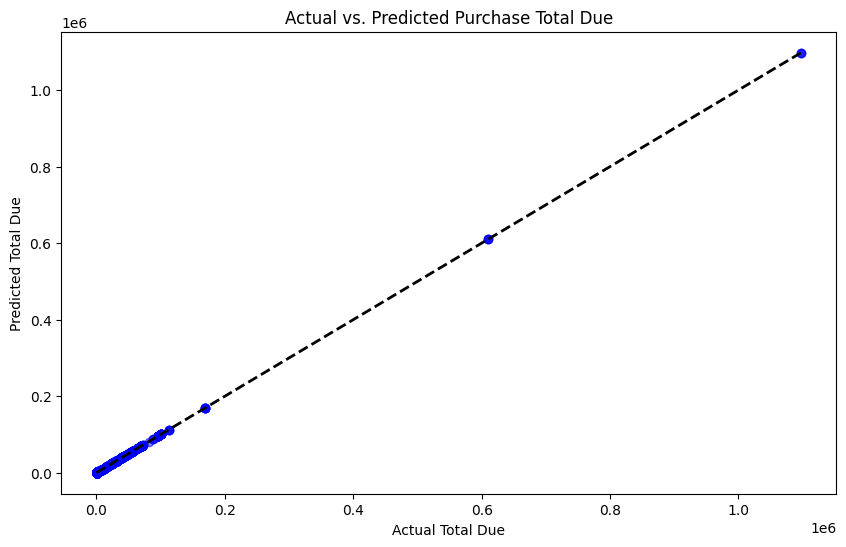

In [74]:

features = [
    'PURCHASE_sub_total', 'PURCHASE_tax_amount', 'PURCHASE_feight',
    'PURCHASE_ship_base', 'PURCHASE_ship_rate', 'PURCHASE_order_quantity',
    'PURCHASE_unit_price', 'PURCHASE_received_quantity',
    'PURCHASE_rejected_quantity', 'PURCHASE_stocked_quantity'
]
X = df_PURCHASE[features]
y = df_PURCHASE['PURCHASE_total_due']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) 
plt.xlabel('Actual Total Due')
plt.ylabel('Predicted Total Due')
plt.title('Actual vs. Predicted Purchase Total Due')
plt.show()


Mean Squared Error: 2860.4098520631837
Mean Absolute Error: 21.077989772268413


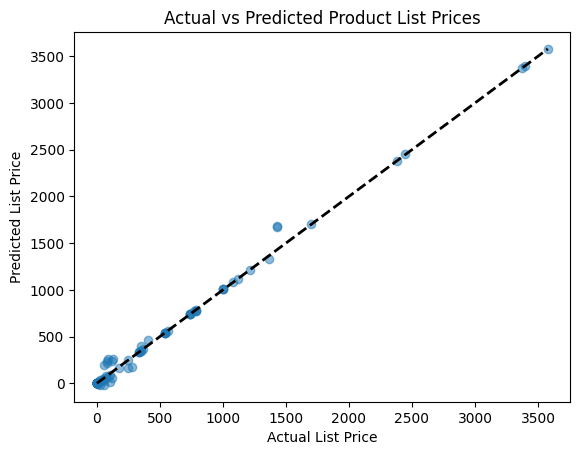

In [77]:

features = [
    'PRODUCT_standard_cost', 'PRODUCT_LINE_code', 'PRODUCT_CLASS_code',
    'PRODUCT_STYLE_code', 'Product_MODEL_name', 'Product_CULTURE_name',
    'PRODUCT_SUBCATEGORY_name', 'PRODUCT_CATEGORY_name', 'PRODUCT_color',
    'Days_Since_Modification'
]
X = df_product[features]
y = df_product['PRODUCT_list_price']


categorical_features = [
    'PRODUCT_LINE_code', 'PRODUCT_CLASS_code', 'PRODUCT_STYLE_code',
    'Product_MODEL_name', 'Product_CULTURE_name', 'PRODUCT_SUBCATEGORY_name',
    'PRODUCT_CATEGORY_name', 'PRODUCT_color'
]
numeric_features = ['PRODUCT_standard_cost', 'Days_Since_Modification']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_pipeline.fit(X_train, y_train)


y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual List Price')
plt.ylabel('Predicted List Price')
plt.title('Actual vs Predicted Product List Prices')
plt.show()